<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Money_Tensor_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 42.3     |
| time/              |          |
|    fps             | 1174     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 88.4        |
| time/                   |             |
|    fps                  | 827         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008622313 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | 8.88e-05    |
|    learning_rate        | 0.

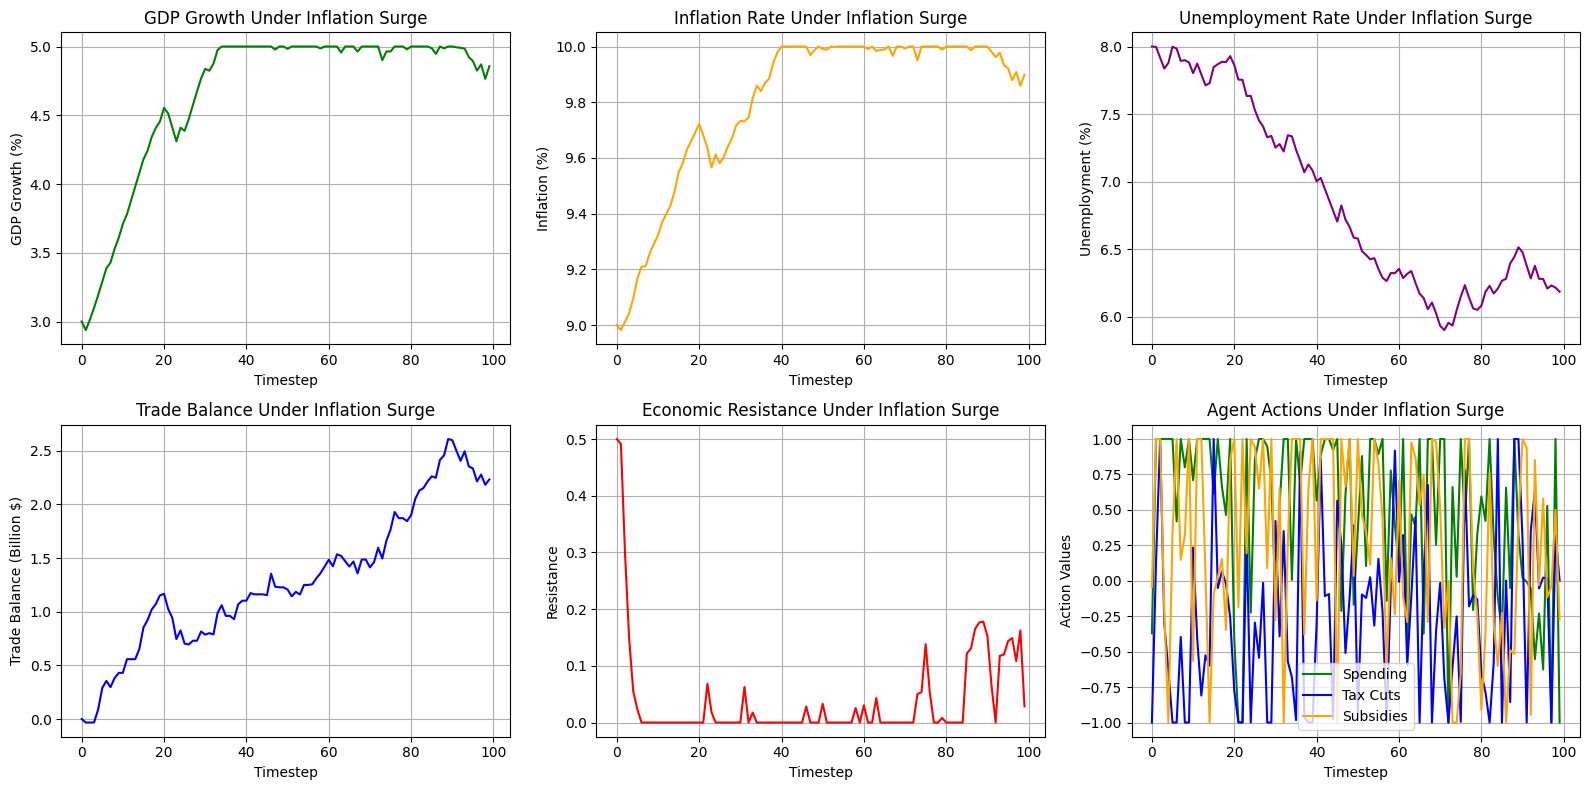

Total Reward Under Inflation Surge: 485.23

Simulating Shock: Trade Deficit


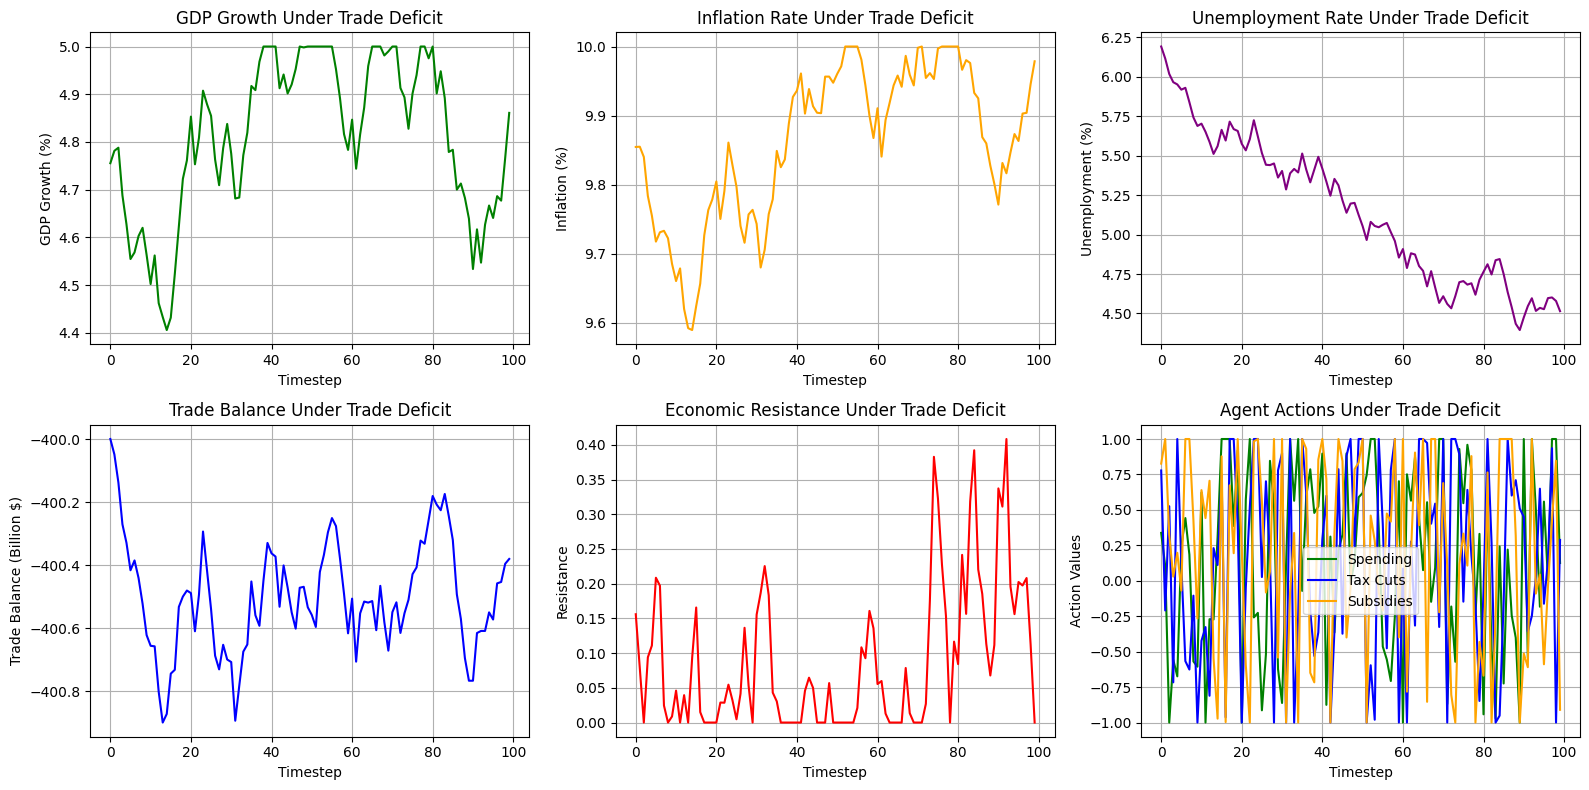

Total Reward Under Trade Deficit: 536.03

Simulating Shock: High Unemployment


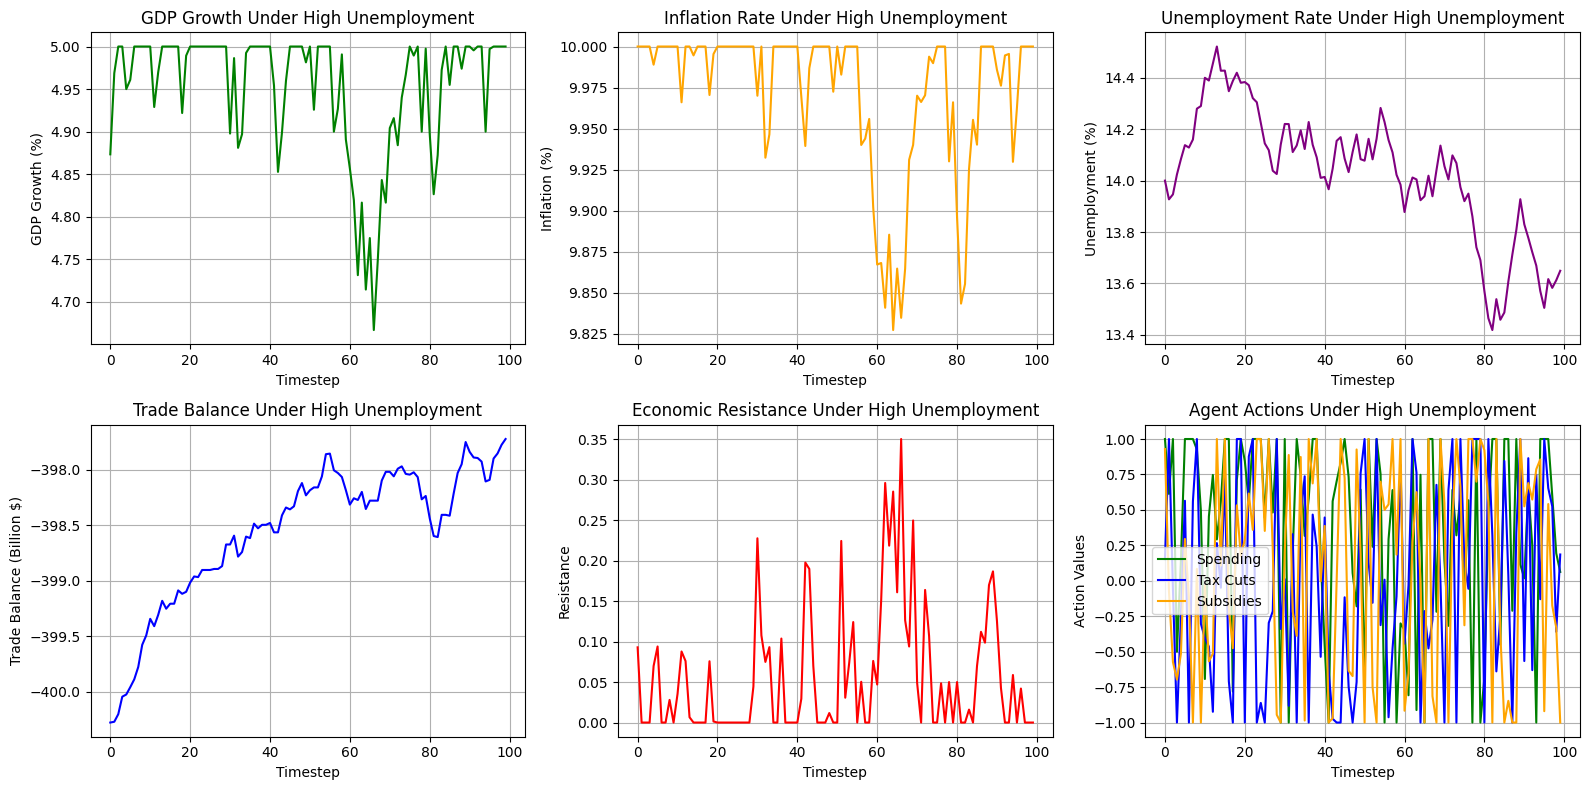

Total Reward Under High Unemployment: 385.88


In [ ]:
!pip install stable-baselines3
!pip install shimmy
!pip install gymnasium

# Import necessary libraries
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Define the Economic Environment
class EconomicEnvironment(gym.Env):
    def __init__(self):
        super(EconomicEnvironment, self).__init__()
        # State: [GDP Growth, Sectoral Productivity, Inflation, Unemployment, Trade Balance, Resistance]
        self.state = np.array([3.0, 100.0, 5.0, 8.0, 0.0, 0.5])  # Initial state
        self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)  # Policy actions
        self.observation_space = spaces.Box(
            low=np.array([0.0, 50.0, 0.0, 0.0, -500.0, 0.0]),
            high=np.array([5.0, 200.0, 10.0, 15.0, 500.0, 1.0]),
            dtype=np.float32,
        )
        self.step_count = 0
        self.max_steps = 100  # Episode length

    def step(self, action):
        # Apply policy actions: [spending, tax cuts, subsidies]
        spending, tax_cut, subsidy = action

        # Update state based on actions
        gdp_growth = self.state[0] + 0.1 * spending - 0.05 * self.state[5]
        resistance = self.state[5] - 0.1 * (spending + subsidy) + 0.05 * tax_cut
        inflation = self.state[2] + 0.05 * spending - 0.02 * subsidy
        unemployment = self.state[3] - 0.1 * subsidy + 0.02 * spending
        trade_balance = self.state[4] + 0.1 * (spending - subsidy)

        # Clamp values within bounds
        gdp_growth = np.clip(gdp_growth, 0.0, 5.0)
        resistance = np.clip(resistance, 0.0, 1.0)
        inflation = np.clip(inflation, 0.0, 10.0)
        unemployment = np.clip(unemployment, 0.0, 15.0)
        trade_balance = np.clip(trade_balance, -500.0, 500.0)

        # Update the state
        self.state = np.array([gdp_growth, self.state[1], inflation, unemployment, trade_balance, resistance])
        self.step_count += 1

        # Refined Reward Function
        reward = (
            2 * gdp_growth                  # Double weight for GDP growth
            - 1.5 * resistance              # Strong penalty for resistance
            - 0.3 * inflation               # Penalty for inflation
            - 0.2 * unemployment            # Penalty for unemployment
            - 0.1 * (spending**2 + tax_cut**2 + subsidy**2)  # Penalty for excessive actions
        )
        done = self.step_count >= self.max_steps

        return self.state, reward, done, {}

    def reset(self):
        # Reset state
        self.state = np.array([3.0, 100.0, 5.0, 8.0, 0.0, 0.5])
        self.step_count = 0
        return self.state

    def render(self, mode="human"):
        print(f"State: {self.state}")


# Create the environment
env = EconomicEnvironment()
vec_env = make_vec_env(lambda: env, n_envs=1)

# Train the PPO Agent
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=50000)  # Train for 50,000 timesteps
model.save("ppo_economic_policy_refined")
trained_model = PPO.load("ppo_economic_policy_refined")

# Function to Simulate Shocks and Test the Agent
def simulate_shocks(env, shock_type):
    print(f"\nSimulating Shock: {shock_type}")

    # Apply specific shock to the initial state
    if shock_type == "Inflation Surge":
        env.state[2] = 9.0  # Set inflation to a high value (9%)
    elif shock_type == "Trade Deficit":
        env.state[4] = -400.0  # Set trade balance to a large deficit (-400B)
    elif shock_type == "High Unemployment":
        env.state[3] = 14.0  # Set unemployment rate to a high value (14%)

    # Reset step count
    env.step_count = 0

    # Simulate the agent's response to the shock
    state = env.state
    done = False
    total_reward = 0
    states = []
    actions = []

    while not done:
        action, _ = trained_model.predict(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Record states and actions
        states.append(state)
        actions.append(action)

        # Update the state
        state = next_state

    # Convert states and actions to arrays
    states = np.array(states)
    actions = np.array(actions)

    return states, actions, total_reward


# Test the agent under different shocks
shocks = ["Inflation Surge", "Trade Deficit", "High Unemployment"]

for shock in shocks:
    states, actions, total_reward = simulate_shocks(env, shock)

    # Visualize results
    time_steps = range(len(states))

    plt.figure(figsize=(16, 8))

    # GDP Growth
    plt.subplot(2, 3, 1)
    plt.plot(time_steps, states[:, 0], label="GDP Growth", color='green')
    plt.title(f"GDP Growth Under {shock}")
    plt.xlabel("Timestep")
    plt.ylabel("GDP Growth (%)")
    plt.grid()

    # Inflation
    plt.subplot(2, 3, 2)
    plt.plot(time_steps, states[:, 2], label="Inflation", color='orange')
    plt.title(f"Inflation Rate Under {shock}")
    plt.xlabel("Timestep")
    plt.ylabel("Inflation (%)")
    plt.grid()

    # Unemployment
    plt.subplot(2, 3, 3)
    plt.plot(time_steps, states[:, 3], label="Unemployment", color='purple')
    plt.title(f"Unemployment Rate Under {shock}")
    plt.xlabel("Timestep")
    plt.ylabel("Unemployment (%)")
    plt.grid()

    # Trade Balance
    plt.subplot(2, 3, 4)
    plt.plot(time_steps, states[:, 4], label="Trade Balance", color='blue')
    plt.title(f"Trade Balance Under {shock}")
    plt.xlabel("Timestep")
    plt.ylabel("Trade Balance (Billion $)")
    plt.grid()

    # Resistance
    plt.subplot(2, 3, 5)
    plt.plot(time_steps, states[:, 5], label="Resistance", color='red')
    plt.title(f"Economic Resistance Under {shock}")
    plt.xlabel("Timestep")
    plt.ylabel("Resistance")
    plt.grid()

    # Agent Actions
    plt.subplot(2, 3, 6)
    plt.plot(time_steps, actions[:, 0], label="Spending", color='green')
    plt.plot(time_steps, actions[:, 1], label="Tax Cuts", color='blue')
    plt.plot(time_steps, actions[:, 2], label="Subsidies", color='orange')
    plt.title(f"Agent Actions Under {shock}")
    plt.xlabel("Timestep")
    plt.ylabel("Action Values")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Total Reward Under {shock}: {total_reward:.2f}")
